<h1>Part 2 : EDA of Data Extracted from Job Postings</h1>

In [12]:
#import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
#import os
from sqlalchemy import create_engine, MetaData, Table, select, distinct

### Load Data

To explore data, first data needs to be loaded from sqlite database.

In [13]:
# import data from sqlite database
engine = create_engine("sqlite:///joblist.sqlite")
metadata = MetaData()
data = Table('data', metadata, autoload=True, autoload_with=engine)

print(repr(data))

Table('data', MetaData(bind=None), Column('jobtitle', VARCHAR(length=100), table=<data>), Column('company', VARCHAR(length=100), table=<data>), Column('location', VARCHAR(length=25), table=<data>), Column('salary', INTEGER(), table=<data>), Column('jobdescription', TEXT(), table=<data>), Column('label', INTEGER(), table=<data>), schema=None)


In [14]:
# Select all data
stmt = select([data], distinct=True)

connection = engine.connect()
results = connection.execute(stmt).fetchall()

In [15]:
# convert data table into a pandas dataframe
data_df = pd.DataFrame(results)
data_df.columns = results[0].keys()

data_df.head()

,jobtitle,company,location,salary,jobdescription,label
0,Pricing Analyst,Day & Ross Inc.,"Mississauga, ON",NaN,Position Title:Pricing Analyst Position Type: ...,0
1,Senior Data Analyst- Telephony Manager,NCRi Inc.,"Mississauga, ON",NaN,Title: Senior Data Analyst - Telephony Manager...,0
2,Fuel Cell Data Engineer / Analyst,Cummins Inc.,"Mississauga, ON",NaN,We are looking for a talented Fuel Cell Data E...,0
3,Senior Meter Data Analyst,Rodan Energy Solutions Inc.,"Mississauga, ON",NaN,CAREER OPPORTUNITY SENIOR METER DATA ANALYST L...,0
4,"Data Engineer, Business Intelligence & Analytics",Herjavec Group,"Toronto, ON",NaN,The Data Engineer reports directly to the Dire...,0


In [16]:
data_df.describe(include='all')

,jobtitle,company,location,salary,jobdescription,label
count,635,635,635,635,635,635.000000
unique,469,373,16,69,628,NaN
top,Data Scientist,BMO Financial Group,"Toronto, ON",NaN,At the Janssen Pharmaceutical Companies of Joh...,NaN
freq,38,21,480,541,2,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.387402
std,NaN,NaN,NaN,NaN,NaN,0.487541
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,1.000000


<h2>Explore Data</h2>

To begin, we will start by exploring the data analyst/scientist job postings.

We will need to summarize the information we collected in the previous step.

In [17]:
# Are there any NaNs in the data?
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jobtitle        635 non-null    object
 1   company         635 non-null    object
 2   location        635 non-null    object
 3   salary          635 non-null    object
 4   jobdescription  635 non-null    object
 5   label           635 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 29.9+ KB


In [18]:
# not all of the data types were detected correctly

dtype_dict = {
    "jobtitle": 'string',
    "company": 'string',
    "location": 'string',
    "salary": 'string',
    "jobdescription": 'string',
    "label": 'int64'
}

data_df = data_df.astype(dtype_dict)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jobtitle        635 non-null    string
 1   company         635 non-null    string
 2   location        635 non-null    string
 3   salary          635 non-null    string
 4   jobdescription  635 non-null    string
 5   label           635 non-null    int64 
dtypes: int64(1), string(5)
memory usage: 29.9 KB


In [19]:
# how many of each label are present?
joblabels = data_df.groupby('label').count()
print(joblabels)

       jobtitle  company  location  salary  jobdescription
label                                                     
0           389      389       389     389             389
1           246      246       246     246             246


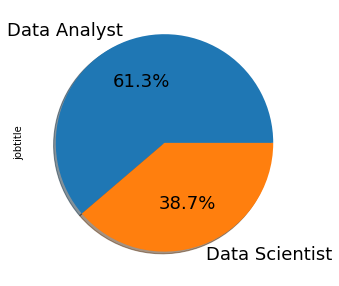

In [20]:
# plot
fig, ax = plt.subplots(figsize = (5,5))
labels = 'Data Analyst', 'Data Scientist'
ax = joblabels['jobtitle'].plot.pie(subplots = True, labels = labels, autopct = '%1.1f%%', shadow = True, fontsize = 18)
plt.show()

This dataset is imbalanced, having more data analyst job descriptions than data scientist job descriptions. This is the result of more data analyst job postings than data scientist postings.

<h3>Job Titles</h3>

The job titles are described by other words to specify the field in which the job position will be in. First, we will simplify the job titles for improved aggregation.

In [21]:
# define a function to simplify job titles

data_df["position"] = data_df["jobtitle"].apply(lambda x: x.lower())
    
data_df.loc[data_df["position"].str.contains("analyst"), "position2"] = "Analyst"
data_df.loc[data_df["position"].str.contains("analytic"), "position2"] = "Analyst"
data_df.loc[data_df["position"].str.contains("business intelligence"), "position2"] = "Business Intelligence"
data_df.loc[data_df["position"].str.contains("bi"), "position2"] = "Business Intelligence"
data_df.loc[data_df["position"].str.contains("machine learning"), "position2"] = "Data Scientist"
data_df.loc[data_df["position"].str.contains("scientist"), "position2"] = "Data Scientist"
data_df.loc[data_df["position"].str.contains("data science"), "position2"] = "Data Scientist"
data_df.loc[data_df["position"].str.contains("engineer"), "position2"] = "Data Engineer"

data_df.head()

,jobtitle,company,location,salary,jobdescription,label,position,position2
0,Pricing Analyst,Day & Ross Inc.,"Mississauga, ON",NaN,Position Title:Pricing Analyst Position Type: ...,0,pricing analyst,Analyst
1,Senior Data Analyst- Telephony Manager,NCRi Inc.,"Mississauga, ON",NaN,Title: Senior Data Analyst - Telephony Manager...,0,senior data analyst- telephony manager,Analyst
2,Fuel Cell Data Engineer / Analyst,Cummins Inc.,"Mississauga, ON",NaN,We are looking for a talented Fuel Cell Data E...,0,fuel cell data engineer / analyst,Data Engineer
3,Senior Meter Data Analyst,Rodan Energy Solutions Inc.,"Mississauga, ON",NaN,CAREER OPPORTUNITY SENIOR METER DATA ANALYST L...,0,senior meter data analyst,Analyst
4,"Data Engineer, Business Intelligence & Analytics",Herjavec Group,"Toronto, ON",NaN,The Data Engineer reports directly to the Dire...,0,"data engineer, business intelligence & analytics",Data Engineer


In [22]:
jobtitle = data_df.groupby(["position2"]).count().sort_values(by=["position2"], ascending=False)

jobtitle.head()

,jobtitle,company,location,salary,jobdescription,label,position
position2,,,,,,,
Data Scientist,139,139,139,139,139,139,139
Data Engineer,41,41,41,41,41,41,41
Business Intelligence,63,63,63,63,63,63,63
Analyst,384,384,384,384,384,384,384


In [23]:
data_df["position2"].isna().sum()

8

In [24]:
data_df.position2.describe()

count         627
unique          4
top       Analyst
freq          384
Name: position2, dtype: object

In [25]:
null_jobs = data_df.loc[data_df['position2'].isna()]
null_jobs

,jobtitle,company,location,salary,jobdescription,label,position,position2
23,Data Visualization Specialist,Mainstreet Research,"Toronto, ON",$40 an hour,ROLE:Our diverse team is growing and we’re loo...,0,data visualization specialist,NaN
423,Conversation Designers,MSi Corp (Bell Canada),"Toronto, ON",$50 an hour,"Our Telecom client, Bell Canada, is looking fo...",1,conversation designers,NaN
430,EMM Specialist,Compugen Inc,"Richmond Hill, ON",NaN,Compugen is one of Canada's top Information Te...,1,emm specialist,NaN
473,Epidemiologist - Predictive Modeling Specialist,BlueDot Inc.,"Toronto, ON",NaN,We currently require a full-time predictive mo...,1,epidemiologist - predictive modeling specialist,NaN
486,"Senior Consultant, Cyber Security, Omnia AI",Deloitte,"Toronto, ON",NaN,"Job Type: Permanent Primary Location: Toronto,...",1,"senior consultant, cyber security, omnia ai",NaN
510,Messaging Specialist,Drake International Inc,"Richmond Hill, ON",NaN,Role Description: The Messaging Specialist wil...,1,messaging specialist,NaN
517,"Manager, Cyber Security, Omnia AI",Deloitte,"Toronto, ON",NaN,"Job Type: Permanent Primary Location: Toronto,...",1,"manager, cyber security, omnia ai",NaN
589,NLP Consultant,Prodigy Systems Inc.,"Toronto, ON",$60 - $90 an hour,Practical experience in NLPExperience in devel...,1,nlp consultant,NaN


After simplifying the job titles, there were 8 jobs that did not fall into any of the categories. These are specialist positions.

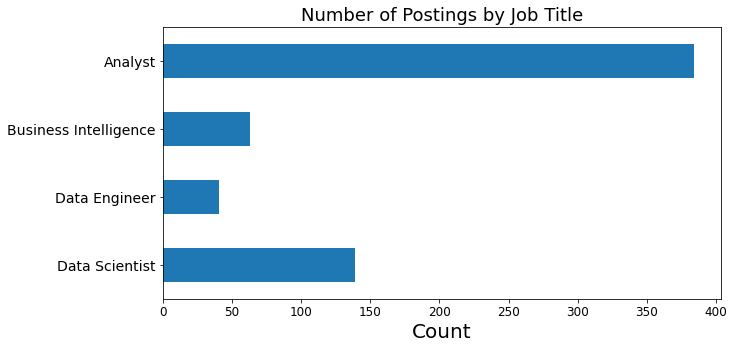

In [26]:
jobtitle['position'].plot(kind='barh',figsize = (10,5))
plt.xlabel('Count', size = 20)
plt.ylabel('')
plt.yticks(size = 14)
plt.xticks(size = 12)
plt.title('Number of Postings by Job Title', size = 18)
plt.show()

In [96]:
import seaborn as sns

jobtitle4 = data_df.groupby('label')['position2'].value_counts(normalize=True)
jobtitle4 = jobtitle4.mul(100)
jobtitle4 = jobtitle4.rename('percent').reset_index()
jobtitle4

,label,position2,percent
0,0,Analyst,85.567010
1,0,Business Intelligence,12.628866
2,0,Data Engineer,1.030928
3,0,Data Scientist,0.773196
4,1,Data Scientist,56.903766
5,1,Analyst,21.757322
6,1,Data Engineer,15.481172
7,1,Business Intelligence,5.857741


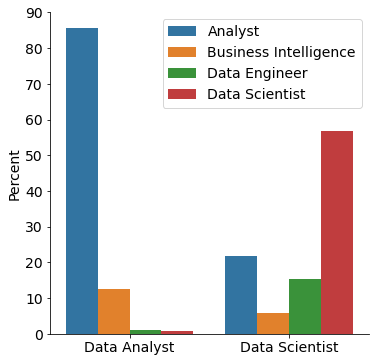

In [95]:
g = sns.catplot(x= 'label', y = 'percent', data= jobtitle4, hue= 'position2', kind= 'bar', legend=False)
plt.xticks(ticks=[0,1], labels= ['Data Analyst', 'Data Scientist'], fontsize=14)
plt.xlabel("")

plt.yticks(fontsize = 14)
plt.ylabel("Percent", fontsize = 14)
g.ax.set_ylim(0, 90)

plt.legend(title=None, loc = 0, fontsize = 14)
plt.show()

<h3>Level of Seniority</h3>

In [99]:
# Level of seniority

data_df.loc[data_df["position"].str.contains(r'intern|student'), "level"] = "Intern"
data_df.loc[data_df["position"].str.contains("junior"), "level"] = "Junior"
data_df.loc[data_df["position"].str.contains("senior"), "level"] = "Senior"
data_df.loc[data_df["position"].str.contains("manager"), "level"] = "Manager"
data_df.loc[data_df["position"].str.contains("director"), "level"] = "Director"

data_df.head()

,jobtitle,company,location,salary,jobdescription,label,position,position2,level
0,Pricing Analyst,Day & Ross Inc.,"Mississauga, ON",NaN,Position Title:Pricing Analyst Position Type: ...,0,pricing analyst,Analyst,NaN
1,Senior Data Analyst- Telephony Manager,NCRi Inc.,"Mississauga, ON",NaN,Title: Senior Data Analyst - Telephony Manager...,0,senior data analyst- telephony manager,Analyst,Manager
2,Fuel Cell Data Engineer / Analyst,Cummins Inc.,"Mississauga, ON",NaN,We are looking for a talented Fuel Cell Data E...,0,fuel cell data engineer / analyst,Data Engineer,NaN
3,Senior Meter Data Analyst,Rodan Energy Solutions Inc.,"Mississauga, ON",NaN,CAREER OPPORTUNITY SENIOR METER DATA ANALYST L...,0,senior meter data analyst,Analyst,Senior
4,"Data Engineer, Business Intelligence & Analytics",Herjavec Group,"Toronto, ON",NaN,The Data Engineer reports directly to the Dire...,0,"data engineer, business intelligence & analytics",Data Engineer,NaN


For the job titles that do not explicitly indicate a level of seniority, replace NaN with 'Unspecified'. Here, the level will likely depend on a candidate's experience.

In [100]:
# For job titles that do not have a explicit level of seniority listed, describe using "unspecified"

data_df.level.fillna("Unspecified", inplace=True)
data_df.head()

,jobtitle,company,location,salary,jobdescription,label,position,position2,level
0,Pricing Analyst,Day & Ross Inc.,"Mississauga, ON",NaN,Position Title:Pricing Analyst Position Type: ...,0,pricing analyst,Analyst,Unspecified
1,Senior Data Analyst- Telephony Manager,NCRi Inc.,"Mississauga, ON",NaN,Title: Senior Data Analyst - Telephony Manager...,0,senior data analyst- telephony manager,Analyst,Manager
2,Fuel Cell Data Engineer / Analyst,Cummins Inc.,"Mississauga, ON",NaN,We are looking for a talented Fuel Cell Data E...,0,fuel cell data engineer / analyst,Data Engineer,Unspecified
3,Senior Meter Data Analyst,Rodan Energy Solutions Inc.,"Mississauga, ON",NaN,CAREER OPPORTUNITY SENIOR METER DATA ANALYST L...,0,senior meter data analyst,Analyst,Senior
4,"Data Engineer, Business Intelligence & Analytics",Herjavec Group,"Toronto, ON",NaN,The Data Engineer reports directly to the Dire...,0,"data engineer, business intelligence & analytics",Data Engineer,Unspecified


In [104]:
joblevel = data_df.groupby(['label'])['level'].value_counts(normalize = True)
joblevel = joblevel.mul(100)
joblevel = joblevel.rename('Percent').reset_index()
joblevel

,label,level,Percent
0,0,Unspecified,79.691517
1,0,Senior,14.652956
2,0,Intern,2.313625
3,0,Junior,1.542416
4,0,Manager,1.542416
5,0,Director,0.257069
6,1,Unspecified,65.040650
7,1,Senior,15.040650
8,1,Manager,11.382114
9,1,Director,3.658537


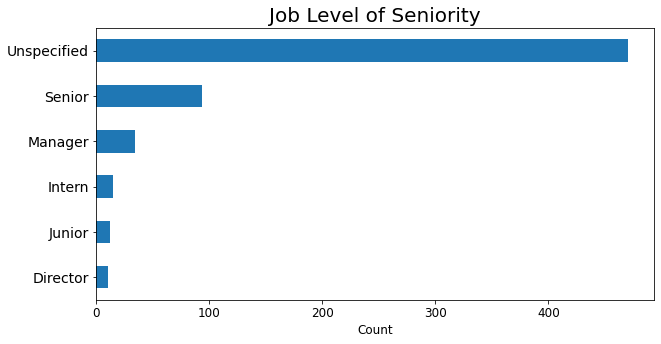

In [19]:
plt.clf

joblevel.plot(kind='barh', figsize=(10,5))
plt.xlabel('Count', size=12)
plt.ylabel('')
plt.xticks(size=12)
plt.yticks(size=14)
plt.title('Job Level of Seniority', size=20)

plt.show()

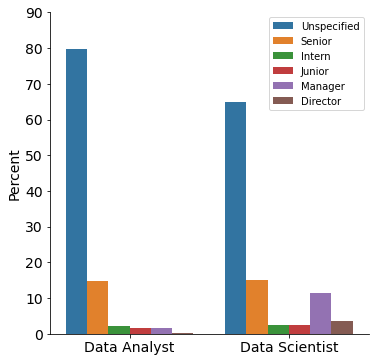

In [108]:
g = sns.catplot(x= 'label', y = 'Percent', data= joblevel, hue= 'level', kind= 'bar', legend=False)
plt.xticks(ticks=[0,1], labels= ['Data Analyst', 'Data Scientist'], fontsize=14)
plt.xlabel("")

plt.yticks(fontsize = 14)
plt.ylabel("Percent", fontsize = 14)
g.ax.set_ylim(0, 90)

plt.legend(title=None, loc = 0)
plt.show()

<h3>Company</h3>

In [20]:
# Is there a type of company that is looking to hire data candidates than others?
company = data_df.groupby(["company"]).count().sort_values('position', ascending=False).head(20)
company.jobtitle

company
BMO Financial Group                      21
Procom                                   17
Scotiabank                               14
TD Bank                                  13
Aviva                                     9
CIBC                                      9
Rogers Communications                     9
Bell Canada                               9
RBC                                       8
MSi Corp (Bell Canada)                    7
Johnson & Johnson Family of Companies     6
Sun Life Financial                        6
Moneris Solutions Corporation             6
Manulife                                  6
IBM                                       5
Wattpad                                   5
Deloitte                                  5
IQ Hunt                                   5
Cognizant Technology Solutions            5
Citi                                      4
Name: jobtitle, dtype: int64

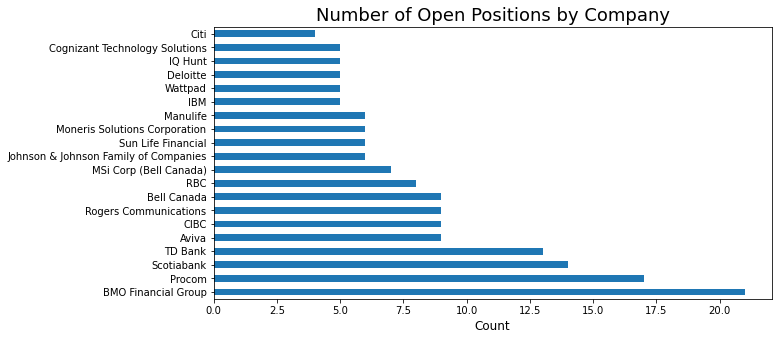

In [21]:
company['position'].plot(kind='barh',figsize = (10,5))
plt.xlabel('Count', size = 12)
plt.ylabel('')
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title('Number of Open Positions by Company', size = 18)
plt.show()

It appears that banks and communication/tech companies are among the top companies that were hiring candidates.
- Procom is a talent acquisition company
- Aviva is an insurance company
- Johnson & Johnson is a healthcare company
- Wattpad is a platform that hosts user-created stories
- Deloitte is a consulting firm
- IQ Hunt is a contract organization for IT projects
- Cognizant Technology Solutions provides digital solutions for businesses

In [174]:
company2 = data_df[data_df['label'] == 0].groupby(['company']).count().sort_values(by = 'position', ascending=False)
company2

,jobtitle,location,salary,jobdescription,label,position,position2,level
company,,,,,,,,
BMO Financial Group,16,16,16,16,16,16,16,16
Procom,14,14,14,14,14,14,14,14
TD Bank,8,8,8,8,8,8,8,8
Scotiabank,8,8,8,8,8,8,8,8
CIBC,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...
HSBC,1,1,1,1,1,1,1,1
Hallmark,1,1,1,1,1,1,1,1
Heart & Stroke,1,1,1,1,1,1,1,1


<h3>Salary</h3>

Next, we will look at the distribution of available salaries. There are many salaries that are not provided in the salary section of the job posting.

In [22]:
# Count the number of salaries available with .describe()
data_df["salary"].describe()

count     635
unique     69
top       NaN
freq      541
Name: salary, dtype: object

In [23]:
# Many jobs do not provide a salary.

salary_df = data_df.loc[(data_df.salary != "NaN") & (data_df.salary.str.contains('\d+'))]
salary_df.head(10)

,jobtitle,company,location,salary,jobdescription,label,position,position2,level
23,Data Visualization Specialist,Mainstreet Research,"Toronto, ON",$40 an hour,ROLE:Our diverse team is growing and we’re loo...,0,data visualization specialist,NaN,Unspecified
38,Business Systems Analyst,TO Live,"Toronto, ON","$60,000 - $70,000 a year",Employment Opportunity Business Systems Analy...,0,business systems analyst,Analyst,Unspecified
48,Inventory Planning Analyst,Manpower,"Rexdale, ON",$23 - $25 an hour,Inventory Planning Analyst - Pay rate $23 per ...,0,inventory planning analyst,Analyst,Unspecified
56,"Senior Analyst, Data Visualization and Analytics",Centennial College,"Scarborough, ON",$41.03 - $47.58 an hour,Job Number: J0321-0815 Job Title: Senior Analy...,0,"senior analyst, data visualization and analytics",Analyst,Senior
63,Business Development Analyst,Origin Merchant Partners,"Toronto, ON","$70,000 a year",Origin Merchant Partners is the largest invest...,0,business development analyst,Analyst,Unspecified
66,marketing analyst,Winful Seafood International Ltd.,"Scarborough, ON",$35 - $38 an hour,Business Equipment and Computer Applications M...,0,marketing analyst,Analyst,Unspecified
69,Research Analyst,North York General Hospital,"Toronto, ON",$25.36 - $30.56 an hour,Company Bio IMAGINE a hospital where everyone ...,0,research analyst,Analyst,Unspecified
73,NEGOTIATIONS ANALYST,Ministry of Health,"Toronto, ON","$63,890 - $89,324 a year","The Ontario Health Insurance Plan Division, Mi...",0,negotiations analyst,Analyst,Unspecified
77,Data Analyst,Parmida E-commerce,"Toronto, ON","$45,000 a year","What we doAt Parmida LED Technologies, we are ...",0,data analyst,Analyst,Unspecified
88,DAX Senior Business Analyst,Flexstaf I.T. Inc.,"Mississauga, ON","$100,000 a year",Position: DAX Senior Business AnalystDuration:...,0,dax senior business analyst,Analyst,Senior


In [121]:
def get_salary(amount):
    '''Return salary in a per year amount.'''
    
    if "an hour" in amount:
        if "-" in amount:
            amt_split = amount.replace(' an hour', '').replace('$', '').split(' - ') # returns list
            for i, num in enumerate(amt_split):
                amt_split[i] = (float(num)) * 40 * 52
            return amt_split[0]
        else:
            amt_split = amount.replace(' an hour', '').replace('$', '')
            amt_split = (float(amt_split)) * 40 * 52
            return amt_split
    
    if "a year" in amount:
        if "-" in amount:
            amt_split = amount.replace(' a year', '').replace(',', '').replace('$', '').split(' - ')
            for i, num in enumerate(amt_split):
                amt_split[i] = float(num)
            return amt_split[0]
        else:
            amt_split = amount.replace(' a year', '').replace(',', '').replace('$', '')
            amt_split = float(amt_split)
            return amt_split
    
    if "a day" in amount:
        if "-" in amount:
            amt_split = amount.replace(' a day', '').replace('$', '').split(' - ') # returns list
            for i, num in enumerate(amt_split):
                amt_split[i] = (float(num)) * 5 * 52
            return amt_split[0]
        else:
            amt_split = amount.replace(' a day', '').replace('$', '')
            amt_split = (float(amt_split)) * 5 * 52
            return amt_split

In [124]:
salary_df['yearly_salary ($)'] = salary_df['salary'].map(get_salary)
salary_df.head()

<ipython-input-124-ea6d71b35dbd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_df['yearly_salary ($)'] = salary_df['salary'].map(get_salary)


,jobtitle,company,location,salary,jobdescription,label,position,position2,level,yearly_salary,yearly_salary ($K),yearly_salary ($)
23,Data Visualization Specialist,Mainstreet Research,"Toronto, ON",$40 an hour,ROLE:Our diverse team is growing and we’re loo...,0,data visualization specialist,NaN,Unspecified,83200.0,83200.0,83200.0
38,Business Systems Analyst,TO Live,"Toronto, ON","$60,000 - $70,000 a year",Employment Opportunity Business Systems Analy...,0,business systems analyst,Analyst,Unspecified,60000.0,60000.0,60000.0
48,Inventory Planning Analyst,Manpower,"Rexdale, ON",$23 - $25 an hour,Inventory Planning Analyst - Pay rate $23 per ...,0,inventory planning analyst,Analyst,Unspecified,47840.0,47840.0,47840.0
56,"Senior Analyst, Data Visualization and Analytics",Centennial College,"Scarborough, ON",$41.03 - $47.58 an hour,Job Number: J0321-0815 Job Title: Senior Analy...,0,"senior analyst, data visualization and analytics",Analyst,Senior,85342.4,85342.4,85342.4
63,Business Development Analyst,Origin Merchant Partners,"Toronto, ON","$70,000 a year",Origin Merchant Partners is the largest invest...,0,business development analyst,Analyst,Unspecified,70000.0,70000.0,70000.0


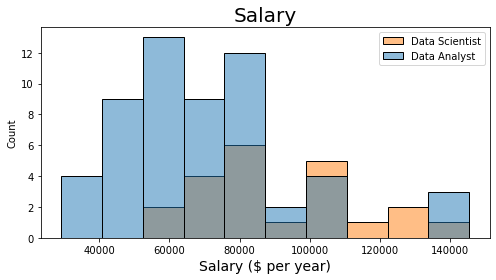

In [153]:
# plot available salaries
fig, ax = plt.subplots(1, 1, figsize=(7,4))
sns.histplot(data = salary_df, x= "yearly_salary ($)", hue = 'label')
plt.title("Salary", fontsize = 20)
plt.xlabel("Salary ($ per year)", fontsize = 14)
plt.ylabel("Count")
plt.legend(labels=["Data Scientist", "Data Analyst"])
plt.tight_layout()
plt.show()

Data scientist salaries are less spread out than data analyst salaries, but surprisingly there are some analyst salaries that are as equally high-paying. As seen below, these high-paying analyst roles are found in the finance sector.

In [135]:
salary_df[salary_df['yearly_salary ($)'] > 100000]

,jobtitle,company,location,salary,jobdescription,label,position,position2,level,yearly_salary,yearly_salary ($K),yearly_salary ($)
111,Pega Business Analyst,PROVISION IT RESOURCES,"Toronto, ON",$50 - $75 an hour,Here are job details: Business AnalystWFH (Tor...,0,pega business analyst,Analyst,Unspecified,104000.0,104000.0,104000.0
133,Business Analyst - Business Intelligence,MSi Corp (Bell Canada),"Toronto, ON",$50 an hour,"Our client, Bell Canada, is looking for a bili...",0,business analyst - business intelligence,Business Intelligence,Unspecified,104000.0,104000.0,104000.0
135,Data Analyst - SAS Programming - $52.00 p/h - ...,CorGTA,"Toronto, ON",$52 an hour,Role: Data Analyst - SAS DevelopmentStructure:...,0,data analyst - sas programming - $52.00 p/h - ...,Analyst,Unspecified,108160.0,108160.0,108160.0
176,Business Analyst - Data Architecture,Aston Carter,"Toronto, ON",$67.50 an hour,Equivalent Experience Description: Our client...,0,business analyst - data architecture,Analyst,Unspecified,140400.0,140400.0,140400.0
334,Business Analyst - Capital Markets,PROVISION IT RESOURCES,"Toronto, ON",$70 - $80 an hour,Here are job detailsBusiness AnalystWFH (Toron...,0,business analyst - capital markets,Analyst,Unspecified,145600.0,145600.0,145600.0
365,Business Analyst/BSA - Wall Street FX,PROVISION IT RESOURCES,"Toronto, ON",$70 - $75 an hour,Must Have Skills: 1. 1 Year (recent project) m...,0,business analyst/bsa - wall street fx,Analyst,Unspecified,145600.0,145600.0,145600.0
416,Data Analytical Scientist,Samiti Technology,"Toronto, ON",$50 - $60 an hour,Samiti Technology Company is actively seeking ...,1,data analytical scientist,Data Scientist,Unspecified,104000.0,104000.0,104000.0
422,Business Intelligence Manager,MSi Corp (Bell Canada),"Toronto, ON",$55 an hour,"Our client, Bell Canada, is looking for a Busi...",1,business intelligence manager,Business Intelligence,Manager,114400.0,114400.0,114400.0
423,Conversation Designers,MSi Corp (Bell Canada),"Toronto, ON",$50 an hour,"Our Telecom client, Bell Canada, is looking fo...",1,conversation designers,NaN,Unspecified,104000.0,104000.0,104000.0
466,Senior ML Engineer - Computer Vision for Facia...,CyberCoders,"Toronto, ON","$130,000 - $160,000 a year",Senior ML Engineer - Computer Vision for Facia...,1,senior ml engineer - computer vision for facia...,Data Engineer,Senior,130000.0,130000.0,130000.0


In [154]:
salary_df.groupby('label').count()

,jobtitle,company,location,salary,jobdescription,position,position2,level,yearly_salary,yearly_salary ($K),yearly_salary ($)
label,,,,,,,,,,,
0,56,56,56,56,56,56,55,56,56,56,56
1,23,23,23,23,23,23,21,23,22,22,22


Overall, only 56 data analyst and 23 data scientist roles included a salary. Upon closer inspection, there appeared to be one data scientist role where the the get_salary function didn't work.